# *In situ* sampling design

In [88]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import glob
import plotly.express as px
from IPython.display import display
from collections import defaultdict

print('All libraries successfully imported!')
print(f'Pandas    : {pd.__version__}')
print(f'GeoPandas : {gpd.__version__}')

All libraries successfully imported!
Pandas    : 1.1.5
GeoPandas : 0.9.0


## Set directory

In [2]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'

in_situ_path = f'{work_path}IN_SITU/'

## Set parameters

In [37]:
site = 'NAMUR'
year = '2020'

field_classif_code = 'sub_nb'
field_classif_name = 'sub'

pix_best = 10
pix_ratio_hi = 0.05
pix_ratio_lo = 0.01

sample_ratio_hi = 0.25
sample_ratio_lo = 0.75

## Open *in situ* data prepared

In [95]:
in_situ_file = f'{in_situ_path}{site}_{year}_IN_SITU_ROI_prepared.shp'

gdf = gpd.read_file(in_situ_file)

display(gdf.head())


,id,sub_nb,sub,grp_nb,grp,class_nb,class,lc_nb,lc,area,pix_count,geometry
0,3,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,1735,17,"MULTIPOLYGON (((630003.573 5594258.004, 630003..."
1,4,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,14331,146,"POLYGON ((636962.589 5595674.757, 636966.536 5..."
2,5,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,1768,18,"POLYGON ((635692.119 5593303.601, 635688.405 5..."
3,6,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,7828,79,"POLYGON ((627911.368 5595749.375, 627942.033 5..."
4,8,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,3197,39,"POLYGON ((633236.525 5596165.100, 633397.286 5..."


## Get `pixel_ratio` for each polygons

pixel_ratio = 

> All polygons from a same class will have the same pixel_ratio !

In [96]:
gdf['crop_pix'] = gdf.groupby(field_classif_code)['pix_count'].transform('sum')

gdf['pix_ratio'] = gdf['crop_pix'] / gdf['pix_count'].sum()

display(gdf.head())

,id,sub_nb,sub,grp_nb,grp,class_nb,class,lc_nb,lc,area,pix_count,geometry,crop_pix,pix_ratio
0,3,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,1735,17,"MULTIPOLYGON (((630003.573 5594258.004, 630003...",23889,0.230404
1,4,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,14331,146,"POLYGON ((636962.589 5595674.757, 636966.536 5...",23889,0.230404
2,5,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,1768,18,"POLYGON ((635692.119 5593303.601, 635688.405 5...",23889,0.230404
3,6,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,7828,79,"POLYGON ((627911.368 5595749.375, 627942.033 5...",23889,0.230404
4,8,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,3197,39,"POLYGON ((633236.525 5596165.100, 633397.286 5...",23889,0.230404


## Assign sampling design strategy for each polygons

- strategy 1 : 
- strategy 2 : 
- strategy 3 : 

In [97]:
gdf['strategy'] = np.where(gdf['pix_count'] < pix_best, 3,
                           np.where(gdf['pix_ratio'] >= pix_ratio_hi, 1, 2))


# Build a table to summarize the strategy assign to each class

df = gdf[[field_classif_code,field_classif_name,'crop_pix','pix_ratio','strategy']].drop_duplicates()

df = df[df['strategy'] != 3].sort_values('pix_ratio', ascending=False)

display(df)

,sub_nb,sub,crop_pix,pix_ratio,strategy
233,1111,Winter wheat,29633,0.285804,1
0,3199,Grassland and meadows,23889,0.230404,1
307,1121,Maize,8667,0.083591,1
343,1811,Sugar beet,7400,0.071371,1
364,1152,Barley six-row,6659,0.064225,1
445,1511,Potatoes,6439,0.062103,1
384,1192,Other cereals,6117,0.058997,1
417,1771,Peas,3606,0.034779,2
495,6999,Forest,3109,0.029986,2
411,1923,"Flax, hemp and other similar crops",2810,0.027102,2


## Split polygons into calibration and validation datasets

In [98]:
training_pixels = defaultdict(lambda: 0)
training_target = {}

cal_id_list = []
val_id_list = []

gdf_shuffle = gdf.sample(len(gdf), random_state=1)

for i, row in gdf_shuffle.iterrows():

    id          = row['id']
    crop_code   = row[field_classif_code]
    crop_pixels = row['crop_pix']
    strategy    = row['strategy']
    pix_count   = row['pix_count']

    if strategy != 3:
        if strategy == 1:
            crop_target = sample_ratio_hi * crop_pixels
            training_target[crop_code] = crop_target
        elif strategy == 2:
            crop_target = sample_ratio_lo * crop_pixels
            training_target[crop_code] = crop_target

        pixels = training_pixels[crop_code]

        if pixels + pix_count <= crop_target:
            training_pixels[crop_code] = pixels + pix_count
            purpose = 0  # calibration
        
        else:
            purpose = 1  # validation
    else:
        purpose = 1  # validation
    
    if purpose == 0:
        cal_id_list.append(id)
    else:
        val_id_list.append(id)


print(len(cal_id_list))
print(len(val_id_list))

cal_gdf = gdf[gdf['id'].isin(cal_id_list)]

val_gdf = gdf[gdf['id'].isin(val_id_list)]


212
318


## Plot calibration and validation *in situ* data

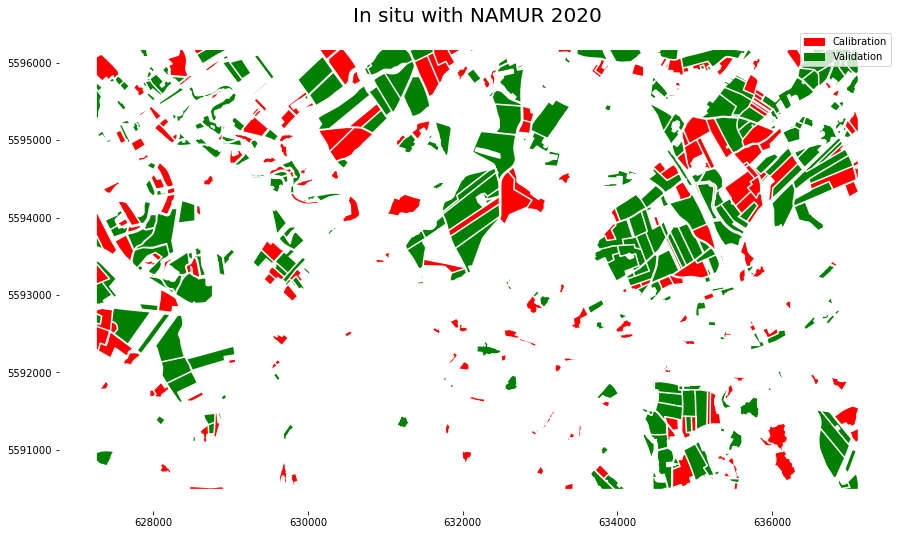

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

cal_gdf.plot(ax=ax,
            color='red')

val_gdf.plot(ax=ax,
            color='green')

ax.set_title(f'In situ with {site} {year}',fontsize=20)

cal_patch = mpatches.Patch(color='red', label='Calibration')
val_patch = mpatches.Patch(color='green', label='Validation')


plt.legend(handles=[cal_patch, val_patch])

plt.box(False)

## Write geodataframe into a shapefile

In [100]:
in_situ_cal_file = f'{in_situ_path}{site}_{year}_IN_SITU_ROI_CAL.shp'
in_situ_val_file = f'{in_situ_path}{site}_{year}_IN_SITU_ROI_VAL.shp'


cal_gdf.to_file(in_situ_cal_file)
val_gdf.to_file(in_situ_val_file)


print(f'Two shapefiles have been created :\n {in_situ_cal_file} \n {in_situ_val_file}')

Two shapefiles have been created :
 /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/IN_SITU/NAMUR_2020_IN_SITU_ROI_CAL.shp 
 /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/IN_SITU/NAMUR_2020_IN_SITU_ROI_VAL.shp
